In [1]:
import numpy as np
import enviroment as e
import algorithms as a
import torch
import random
import matplotlib.pyplot as plt
from trainFunctions import train_source, train_stepReward
from plotFunction import plot_stepRegret, plot_stepReward, plot_totalReward, plot_stepPZ

# For autoreloading the imported moduls
%load_ext autoreload
%autoreload 2

## Setting up 

In [12]:
# setting the seeds
seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True


# setting the invariant proxy generaliation mechanism p(w|z) and passive action generaing p(x|z) 
proxyGivenZ = [np.array([1,2,3,4,5]).reshape(1,-1), np.array([1,2,3,4,5]).reshape(1,-1)]
pXgivenZ = [0.8, 0.1]

device = torch.device("cpu")
print(device)


# setting LinUCB agents
agents = [a.LinUCB(k=2, num_features=5, alpha =0.5, leran_flag= True), a.LinUCB(k=2, num_features=5, alpha =0.5, leran_flag=True)]

# setting the hyperparameter for causal agent
num_causal_agent = 1
beta = [0.01]
frequency = [1]
memory_size = [1000]
lr = [0.06]

assert num_causal_agent == len(beta)
assert num_causal_agent == len(frequency)
assert num_causal_agent == len(memory_size)
assert num_causal_agent == len(lr)

# setting Causal agents
for i in range(num_causal_agent):
    agents.append(a.CausalAgent(k=2, dim_proxy=5, batch_size= 32, network='single_encoder', lr = lr[i], memory_size=memory_size[i], beta = beta[i], alpha=1, frequency=frequency[i], device = device))
    # transfer the ture p(w|z) to the causal agent
    agents[i+2].transfer(proxyGivenZ)


cpu


## Souce domain

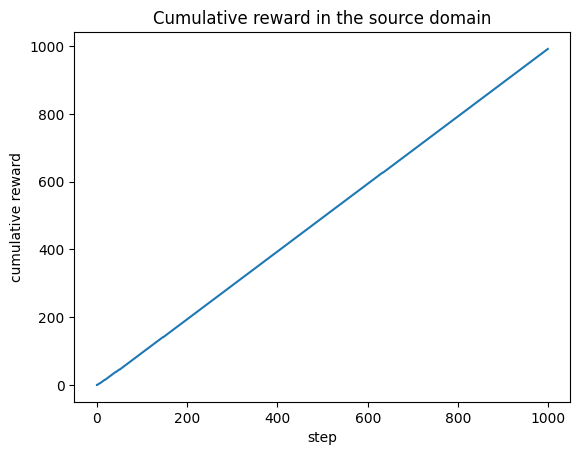

In [13]:
# setting the dist of z
pZ_source = [8, 1] 

# initalize the source domain
source_domain = e.proxyModel(pZ_source, pXgivenZ, proxyGivenZ)

# train the first LinUCB agent in the source domain
rewards = train_source(source_domain, agents[0], steps = 1000)
plt.plot(rewards)
plt.xlabel("step")
plt.ylabel("cumulative reward")
plt.title('Cumulative reward in the source domain')
plt.show()

# transfer the learnd paramerters to the target domain
agents[0].transfer()

## Target Domain

transfered A and b
A for arm 0: 
 [[  83083.03582724  163467.93285968  245754.96975422  327242.25406061
   409253.59887674]
 [ 163467.93285968  326613.39852753  489478.96357936  651868.98781293
   815049.67211717]
 [ 245754.96975422  489478.96357936  736502.93328746  979622.59420549
  1224883.20382379]
 [ 327242.25406061  651868.98781293  979622.59420549 1305671.40129804
  1631436.41366743]
 [ 409253.59887674  815049.67211717 1224883.20382379 1631436.41366743
  2040792.55288429]]
A for arm 1: 
 [[  461.13709244   902.47945251  1359.69207559  1804.15706622
   2261.20023801]
 [  902.47945251  1827.28446704  2735.73270423  3615.06488664
   4532.25320784]
 [ 1359.69207559  2735.73270423  4152.69221106  5474.43878284
   6858.0031059 ]
 [ 1804.15706622  3615.06488664  5474.43878284  7242.38260072
   9064.82696591]
 [ 2261.20023801  4532.25320784  6858.0031059   9064.82696591
  11370.29020931]]
b for arm 0: 
 [[ 8972.82836653]
 [17872.0822916 ]
 [26855.79123462]
 [35764.47050684]
 [44721.2972

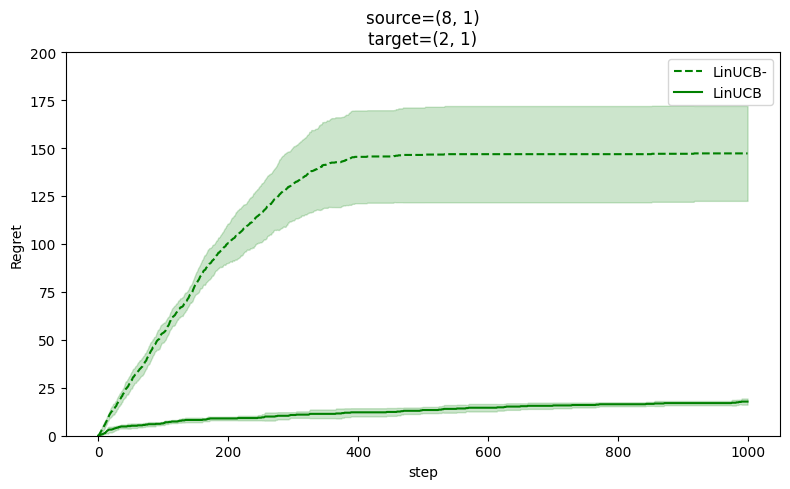

In [19]:


print('transfered A and b')


print('A for arm 0: \n',agents[0].A[0])
print('A for arm 1: \n',agents[0].A[1])
print('b for arm 0: \n',agents[0].b[0])
print('b for arm 1: \n',agents[0].b[1])
print('------------------')

# target domain
pZ_target = [2, 1]
target_domain = e.proxyModel(pZ_target, pXgivenZ, proxyGivenZ)

# deployment in target domain

nEpisodes = 5
steps = 1000

STEP_mean = []
STEP_std = []
REGRET_mean = []
REGRET_std = []
TOTAL_rewards = []


for agent in agents:
    if  isinstance(agent, a.CausalAgent):
        step_mean, step_std, regret_mean, regret_std, total_rewards = train_stepReward(target_domain, nEpisodes, steps, agent, optimal=1)
    else:
        step_mean, step_std, regret_mean, regret_std, total_rewards = train_stepReward(target_domain, nEpisodes, steps, agent, optimal=1)
    STEP_mean.append(step_mean)
    STEP_std.append(step_std)
    REGRET_mean.append(regret_mean) 
    REGRET_std.append(regret_std)
    TOTAL_rewards.append(total_rewards)


labels = ['LinUCB-', 'LinUCB', 'Causal']
name = 'challenge_linear.text'

plot_stepRegret(name, REGRET_mean, REGRET_std, labels, pZ_source, pZ_target)

 